# MF limit ODE decomposition

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
def ode_system_D(t, state_vec, beta1_scaled, beta2_scaled, mu_recovery):
    """ System of ODEs (D) for y, p, and h proportions. """
    y, p, h = state_vec
    y = max(y, 0.0)
    p = min(max(p, 0.0), y)
    h = min(max(h, 0.0), y)

    # prevent negative if y gets > 1
    y_term = y * (1.0 - y) if 0.0 <= y <= 1.0 else 0.0 
    y_sq_term = y**2 * (1.0 - y) if 0.0 <= y <= 1.0 else 0.0

    dydt = beta1_scaled * y_term + (beta2_scaled / 2.0) * y_sq_term - mu_recovery * y
    dpdt = beta1_scaled * y_term - mu_recovery * p
    dhdt = (beta2_scaled / 2.0) * y_sq_term - mu_recovery * h

    return [dydt, dpdt, dhdt]

In [4]:
def solve_system_D(N, I0, beta1_scaled, beta2_scaled, mu_recovery, time_max, num_steps=101):
    """ Solves the system (D) of ODEs using solve_ivp. """
    # Calculate scaled parameters
    # beta1_scaled = beta1 * N
    # beta2_scaled = beta2 * (N**2)

    # initial conditions
    y0 = I0 / N
    # TOOD: could assume infections are PW for simplicity? 
    # or any split such that p0 + h0 = y0
    # p0 = y0
    p0 = 0
    h0 = 0.0
    initial_state = [y0, p0, h0]

    # time span and evaluation points
    t_span = (0.0, time_max)
    t_eval = np.linspace(t_span[0], t_span[1], num_steps)

    # solve the ODE system
    sol = solve_ivp(
        ode_system_D,
        t_span,
        initial_state,
        method='LSODA',
        t_eval=t_eval,
        args=(beta1_scaled, beta2_scaled, mu_recovery)
    )

    return sol

In [34]:
# --- Setup ---
N_test = 1000
I0_test = 10
time_max = 20.0
mu_recovery = 1.0

# scaled
beta1 = 2 #/ N_test
beta2 = 18.0 #/ (N_test**2)

solution_D = solve_system_D(
    N_test, I0_test, beta1, beta2, mu_recovery, time_max)

# extract results
t = solution_D.t
y = solution_D.y[0]
p = solution_D.y[1]
h = solution_D.y[2]

# check the sum p(t) + h(t)
p_plus_h = p + h

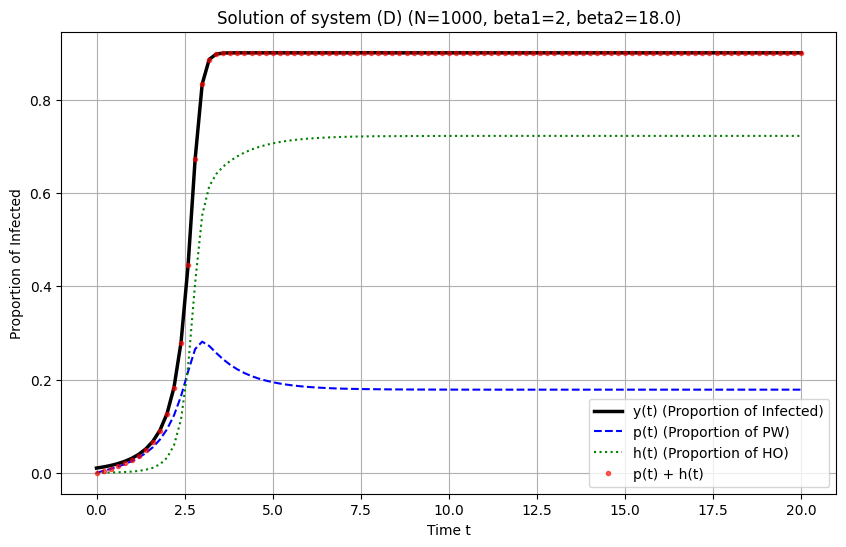

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(t, y, 'k-', linewidth=2.5, label='y(t) (Proportion of Infected)')
plt.plot(t, p, 'b--', linewidth=1.5, label='p(t) (Proportion of PW)')
plt.plot(t, h, 'g:', linewidth=1.5, label='h(t) (Proportion of HO)')

# check that sum p + h matches y
plt.plot(t, p_plus_h, 'ro', markersize=3, alpha=0.6, label='p(t) + h(t)')

plt.xlabel("Time t")
plt.ylabel("Proportion of Infected")
plt.title(f"Solution of system (D) (N={N_test}, beta1={beta1}, beta2={beta2})")
plt.legend()
plt.grid(True)
# plt.ylim(bottom=-0.05) # start with 0
plt.show()

In [12]:
# sum matches
difference = y - p_plus_h
print(f"\n max abs difference between y(t) and p(t) + h(t): {np.max(np.abs(difference)):.2e}")
print(f" mean abs difference between y(t) and p(t) + h(t): {np.mean(np.abs(difference)):.2e}")


 max abs difference between y(t) and p(t) + h(t): 4.00e-03
 mean abs difference between y(t) and p(t) + h(t): 4.16e-04
